# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [18]:
import pandas as pd                 
import numpy as np                                       
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import warnings
import scipy.ndimage as ndi
import unet_tf
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline                  

In [ ]:
tf.test.gpu_device_name()

## Loading Images

### Parameters

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'
LOGS_DIR_NAME = 'logs' 
SAVES_DIR_NAME = 'saves'

MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
#MASK_CATEGORIES = ['trophozoite']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)

min_object_size = 1 
CW_DIR = os.getcwd()

In [3]:
str_masks_name = '_'.join(MASK_CATEGORIES)

In [4]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy',allow_pickle=True)
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy',allow_pickle=True)
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)
#train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_512_512_names.npy',allow_pickle=True)
#X_train = np.load(TRAIN_PATH+'malaria_train_transformed_512_512.npy',allow_pickle=True)
#Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_512_512_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [5]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy',allow_pickle=True)
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy',allow_pickle=True)
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)
#test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_512_512_names.npy',allow_pickle=True)
#X_test = np.load(TRAIN_PATH+'malaria_test_transformed_512_512.npy',allow_pickle=True)
#Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_512_512_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [7]:
print(X_train.shape)
print(Y_train.shape)

(1208, 256, 256, 3)
(1208, 256, 256, 1)


In [8]:
print(X_test.shape)
print(Y_test.shape)

(120, 256, 256, 3)
(120, 256, 256, 1)


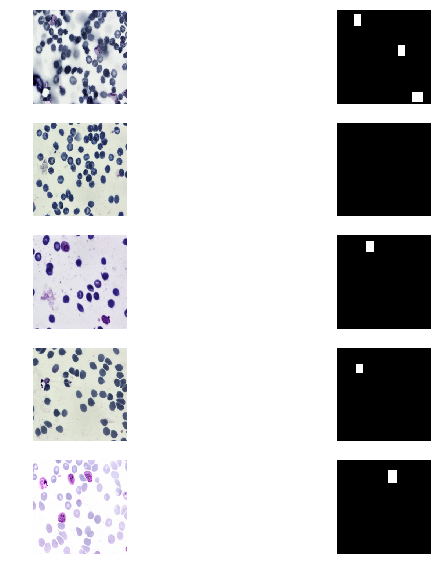

In [9]:
n_images = 5

fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### BALANCE DATA SET

In [10]:
n_images = train_ids.shape[0]

count_no_mask = 0
count_img_mask = 0
rand_filter_count = 0
delete_index = []

for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    if (np.sum(Y_train[i].reshape(-1)) > 0):
        count_img_mask += 1
    else:
        count_no_mask += 1
        if (np.random.rand(1) > 1 ):
            rand_filter_count += 1
        else:
            delete_index.append(i)
        

print("Total images: " + str(n_images))
print("Total images without masks: " + str(count_no_mask))
print("Total images without masks with filter: " + str(rand_filter_count))
print("Total images with masks: " + str(count_img_mask))
print(len(delete_index))

Total images: 1208
Total images without masks: 320
Total images without masks with filter: 0
Total images with masks: 888
320


In [11]:
X_train_balanced = np.delete(X_train, delete_index, 0)
Y_train_balanced = np.delete(Y_train, delete_index, 0)

In [12]:
print(X_train_balanced.shape)
print(Y_train_balanced.shape)

(888, 256, 256, 3)
(888, 256, 256, 1)


### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cap I_2}{I_1 \cup I_2}
\end{equation*}

#### Precision and Recall
\begin{equation*}
Recall = \frac{TP}{TP + FN}
\end{equation*}

\begin{equation*}
Precision= \frac{TP}{TP + FP}
\end{equation*}


In [6]:
def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

In [74]:
def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred) 
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    summary_metrics = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            #prec = tp/(tp+fp+fn)
            prec = tp/(tp+fp)
        else: 
            prec = 0
            
        if (tp+fn) > 0:
            rec = tp/(tp+fn)
        else:
            rec = 0
            
        summary.append([threshold, prec, tp, fp, fn])
        summary_metrics.append([np.mean(iou), prec,rec, n_true_labels, n_pred_labels])

    summary = np.array(summary)
    summary_metrics = np.array(summary_metrics)
    
    score = np.mean(summary[:,1]) # Final score.
    metrics = summary_metrics.mean(0)
    
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict, metrics

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    metrics = []
    for i in range(len(y_true)):
        score, _, m = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
        metrics.append(m)
    return np.array(scores), np.array(metrics)


In [75]:
def trsf_proba_to_binary(y_data, iter= 5):
    """Transform propabilities into binary values 0 or 1.""" 
    y = np.greater(y_data,.5)
    y_bc = ndi.binary_dilation(y, iterations=iter)
    return y_bc.astype(np.uint8)



def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

## U-Net

![title](../../u-net-architecture.png)

#### F1 Score
\begin{equation*}
F_1 = \frac{2TP}{2TP + FP + FN}
\end{equation*}

#### Bray–Curtis dissimilarity
\begin{equation*}
d = 1 - \frac{X \cap Y}{|X| + |Y|}
\end{equation*}

## Train Model

- unet-malaria_256_256_201908032240_trophozoite
    - final train/valid loss = 0.1483/0.1085
    - final train/valid score = 0.5107/0.6053
- unet-malaria_256_256_201908040034_trophozoite
    - final train/valid loss = 0.2225/0.1347
    - final train/valid score = 0.4661/0.4923

In [17]:
TODAY =  datetime.datetime.now().strftime("%Y%m%d%H%M")
nn_name = "unet-malaria_" + str(IMG_WIDTH) + "_" + str(IMG_HEIGHT) \
+ "_" +TODAY + "_" + str_masks_name 
nn_name

'unet-malaria_256_256_201908212311_trophozoite_ring_schizont_gametocyte'

#### Split the data set

In [19]:
cv_num = 15
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=42)

In [20]:
for i,(train_index, valid_index) in enumerate(kfold.split(X_train_balanced)):
    print("## Kfold id:" + str(i))
    # Start timer
    start = datetime.datetime.now();

    # Split into train and validation 
    #x_trn = X_train_balanced[train_index]
    #y_trn = Y_train_balanced[train_index]
    
    #x_vld = X_train_balanced[valid_index]
    #y_vld = Y_train_balanced[valid_index]
    x_trn = X_train[train_index]
    y_trn = Y_train[train_index]
    
    x_vld = X_train[valid_index]
    y_vld = Y_train[valid_index]
    print(x_trn.shape)
    # Choose a certain fold.
    if i==0:
        # Create and start training of a new model.
        
        u_net = NeuralNetwork(nn_name=nn_name, log_step=1.0, input_shape=(256,256,3), 
                              output_shape=(256,256,1), mb_size = 10) # Create instance of neural network.
        u_net.build_graph() # Build graph.

        # Start tensorflow session.
        with tf.Session(graph=u_net.graph) as sess: 
            u_net.attach_saver() # Attach saver tensor.
            u_net.attach_summary(sess) # Attach summaries.
            sess.run(tf.global_variables_initializer()) # Variable initialization.

            # Training on original data.
            u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=50)

            u_net.save_model(sess) # Save parameters, tensors, summaries.

        # Continue training of a pretrained model.
    else:
        u_net = NeuralNetwork() 
        sess = u_net.load_session_from_file(nn_name)  
        u_net.attach_saver() 
        u_net.attach_summary(sess) 

        # Training on original data.
        u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=25) 


        u_net.save_model(sess) # Save parameters, tensors, summaries.

print('Total running time: ', datetime.datetime.now() - start)

## Kfold id:0
(828, 256, 256, 3)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Build UNet Graph: 10 layers, 1766785 trainable weights
loss Jaccard
Instructions for updating:
Use tf.cast instead.
Training the Neural Network
	nn_name = unet-malaria_256_256_201908212311_trophozoite_ring_schizont_gametocyte, n_epoch = 50, mb_size = 10, learnrate = 0.0010000
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0010000000, learn_rate_0 = 0.0010000000, learn_rate_alpha = 0.25
	learn_rate_step = 3, learn_rate_pos = 0, dropout_proba = 0.1
	x_train = (828, 256, 256, 3), x_valid = (60, 256, 256, 3)
	y_train = (828, 256, 256, 1), y_valid = (60, 256, 

INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908182030_trophozoite_ring_schizont_gametocyte
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908182030_trophozoite_ring_schizont_gametocyte, epoch = 400.18, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 133, learn_rate_alpha = 0.25
final train/valid loss = 0.1241/0.1863
final train/valid score = nan/nan


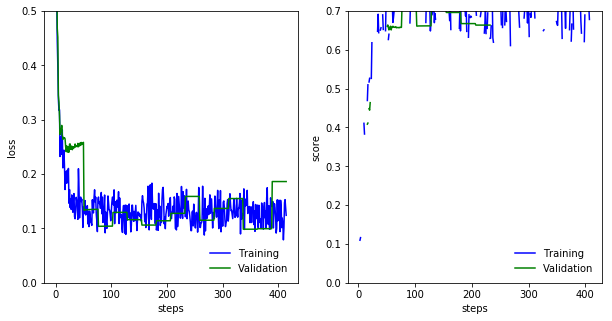

In [20]:
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(nn_name)
sess.close()
train_loss = u_net.params['train_loss']
valid_loss = u_net.params['valid_loss']
train_score = u_net.params['train_score']
valid_score = u_net.params['valid_score']

print('final train/valid loss = {:.4f}/{:.4f}'.format(train_loss[-1], valid_loss[-1]))
print('final train/valid score = {:.4f}/{:.4f}'.format(train_score[-1], valid_score[-1]))
plt.figure(figsize=(10, 5));
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(train_loss)), train_loss,'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss)), valid_loss,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(top = 0.5, bottom = 0.0)
plt.ylabel('loss')
plt.xlabel('steps');

plt.subplot(1,2,2);
plt.plot(np.arange(0,len(train_score)), train_score,'-b', label='Training')
plt.plot(np.arange(0,len(valid_score)), valid_score,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(top = 0.7, bottom = 0.0)
plt.ylabel('score')
plt.xlabel('steps');

### IMAGE |  MASK | PREDICTION

In [18]:
cv_num = 15
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=42)

In [19]:
for i,(train_index, valid_index) in enumerate(kfold.split(X_train_balanced)):
    #print("## Kfold id:" + str(i))
    # Start timer
    if i==1:
        # Split into train and validation 
        x_trn = X_train_balanced[train_index]
        y_trn = Y_train_balanced[train_index]

        x_vld = X_train_balanced[valid_index]
        y_vld = Y_train_balanced[valid_index]

In [ ]:
x_trn.shape

In [17]:
nn_name = "unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte"
#nn_name

In [17]:
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(nn_name, allow_growth=True)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte, epoch = 400.11, mb_size = 10
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 133, learn_rate_alpha = 0.25


### Overall score on train set.

X_train_balanced
Y_train_balanced

In [23]:
s = 70
train_index = np.random.randint(low=0, high=888, size=s)
valid_index = np.random.randint(low=0, high=888, size=s)

In [24]:
x_trn = X_train_balanced[train_index]
y_trn = Y_train_balanced[train_index]

x_vld = X_train_balanced[valid_index]
y_vld = Y_train_balanced[valid_index]

In [25]:
y_train_pred = trsf_proba_to_binary(u_net.get_prediction(sess, x_trn))
train_score, metrics = get_score(y_trn, y_train_pred)

tmp = np.concatenate([train_index.reshape(-1,1), train_score.reshape(-1,1)], axis=1)
train_score_df = pd.DataFrame(tmp, columns=(['train_index','train_score']))
print(train_score_df.describe())
print('')
print(train_score_df.sort_values(by='train_score', ascending=True).head())

       train_index  train_score
count    70.000000    70.000000
mean    422.942857     0.686338
std     258.292940     0.224386
min      25.000000     0.142857
25%     194.000000     0.533333
50%     391.000000     0.741667
75%     651.500000     0.900000
max     883.000000     1.000000

    train_index  train_score
22        274.0     0.142857
48        274.0     0.142857
63        443.0     0.225000
56        725.0     0.266667
42        623.0     0.283333


In [ ]:
np.array(np.array(metrics)[:,1])
#np.array(metrics[0]).mean(0)

In [ ]:
a = np.array(metrics).reshape()
a[:]

### Overall score on validation set.

/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in long_scalars



            index  valid_index  valid_score
count  70.000000    70.000000    66.000000
mean   34.500000   435.842857     0.663900
std    20.351085   243.488394     0.248738
min     0.000000     3.000000     0.000000
25%    17.250000   258.000000     0.462500
50%    34.500000   410.500000     0.700000
75%    51.750000   636.750000     0.891667
max    69.000000   878.000000     1.000000

     index  valid_index  valid_score
10   10.0        231.0        0.000
11   11.0        878.0        0.060
27   27.0          3.0        0.200
16   16.0        395.0        0.225
3     3.0        767.0        0.250


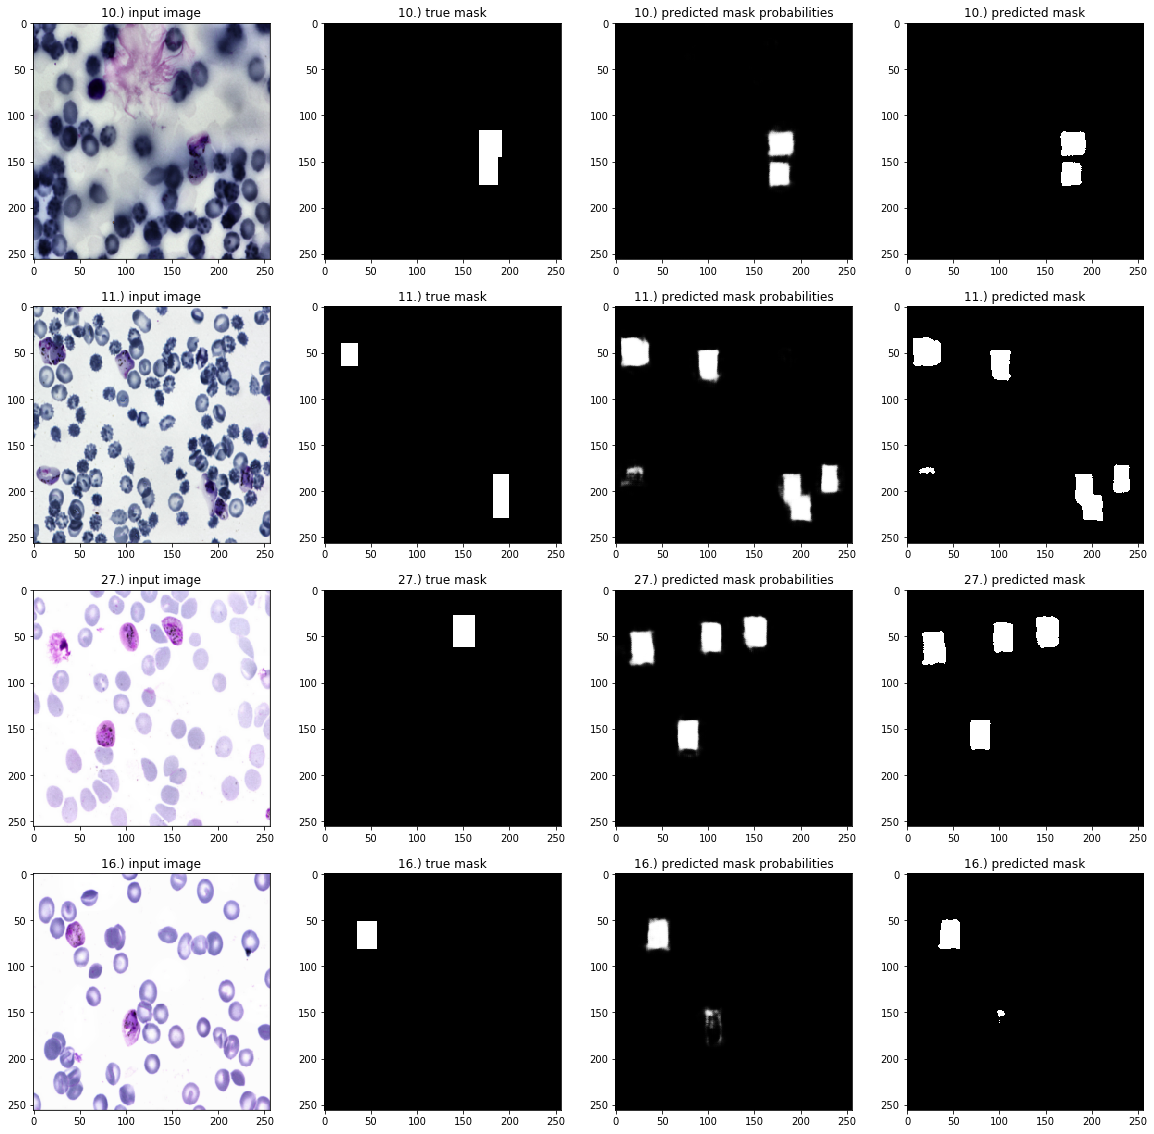

In [27]:
y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
valid_score, valid_metics = get_score(y_vld, y_valid_pred)
tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                      valid_index.reshape(-1,1),
                      valid_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
print('\n', valid_score_df.describe())
print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())

# Plot the worst 4 predictions.
fig, axs = plt.subplots(4,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:4]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

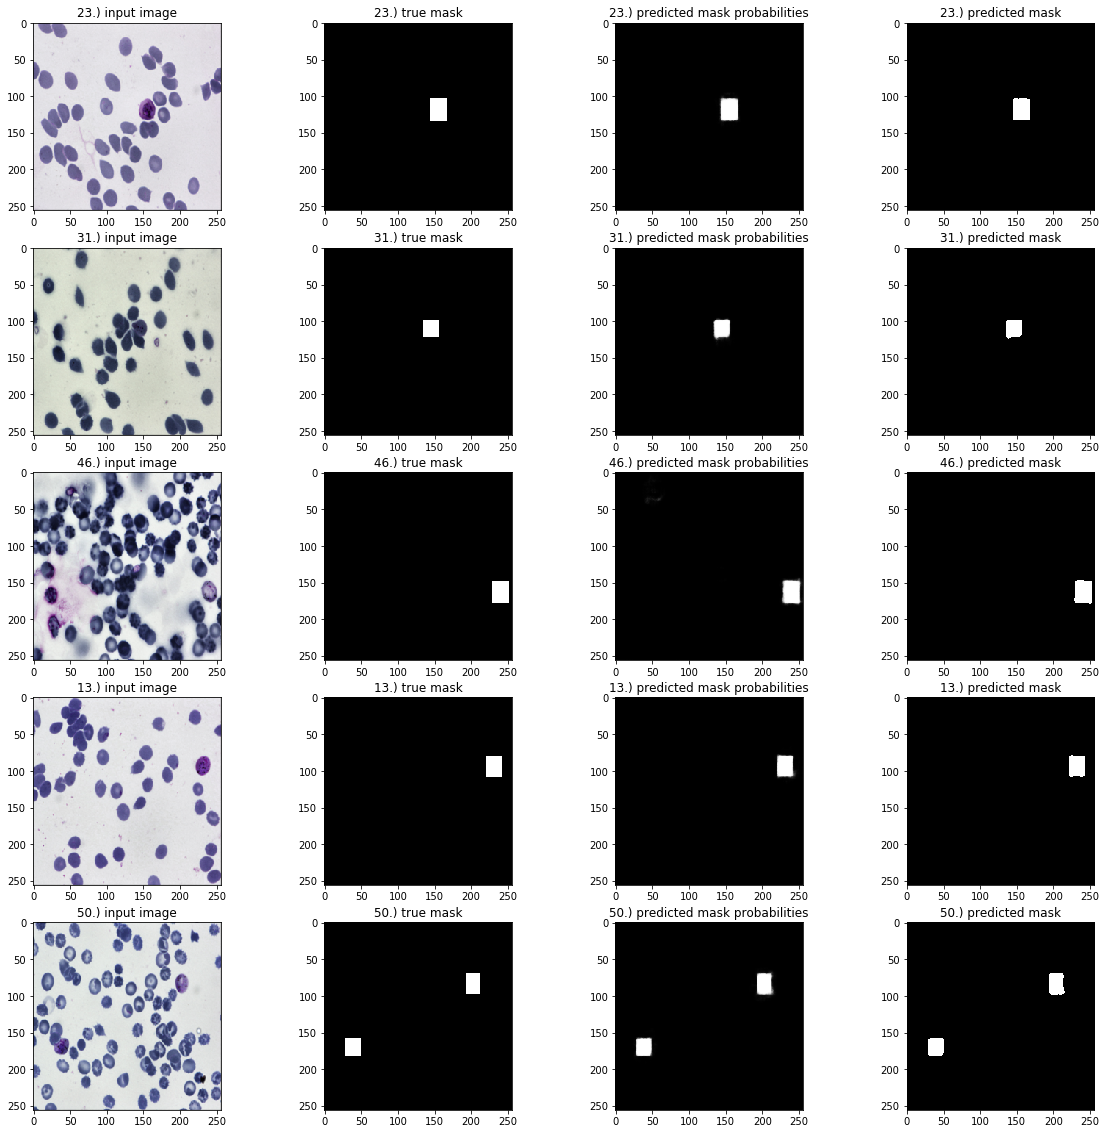

In [28]:
# Plot the best 5 predictions.
fig, axs = plt.subplots(5,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=False)[:5]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

# TEST DATA SET

- X_test
- Y_test

In [76]:
nn_name = "unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte"

In [77]:
u_net = unet_tf.NeuralNetwork()
sess = u_net.load_session_from_file(nn_name, allow_growth=True)

/home/erick/Documents/bioinformatic_thesis_project/code/training/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte.meta
INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte, epoch = 400.11, mb_size = 10
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 133, learn_rate_alpha = 0.25


In [78]:
test_index = np.arange(0,X_test.shape[0])

In [79]:
y_test_pred_proba = u_net.get_prediction(sess, X_test)
y_test_pred = trsf_proba_to_binary(y_test_pred_proba)
test_score, test_metrics= get_score(Y_test, y_test_pred)

/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [80]:
tmp = np.concatenate([np.arange(len(test_index)).reshape(-1,1),
                      test_index.reshape(-1,1),
                      test_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'test_index','valid_score']))
print('\n', valid_score_df.describe())
print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())




             index  test_index  valid_score
count  120.000000  120.000000   120.000000
mean    59.500000   59.500000     0.001499
std     34.785054   34.785054     0.004908
min      0.000000    0.000000     0.000000
25%     29.750000   29.750000     0.000000
50%     59.500000   59.500000     0.000000
75%     89.250000   89.250000     0.000000
max    119.000000  119.000000     0.029412

     index  test_index  valid_score
0     0.0         0.0          0.0
87   87.0        87.0          0.0
86   86.0        86.0          0.0
85   85.0        85.0          0.0
83   83.0        83.0          0.0


### Test Data Set Metrics

In [81]:
print("Avg. Test data set IoU       : " + str(np.nanmean(test_metrics[:,0])))
print("Avg. Test data set Precision : " + str(np.nanmean(test_metrics[:,1])))
print("Avg. Test data set Recall    : " + str(np.nanmean(test_metrics[:,2])))

Avg. Test data set IoU       : 0.20578276592326025
Avg. Test data set Precision : 0.0014985829802006273
Avg. Test data set Recall    : 0.00838888888888889


In [82]:
print("Total true Labels      :" + str(np.sum(test_metrics[:,3])))
print("Total predicted Labels :" + str(np.sum(test_metrics[:,4])))

Total true Labels      :284.0
Total predicted Labels :1839.0


### Plot the worst 5 predictions.

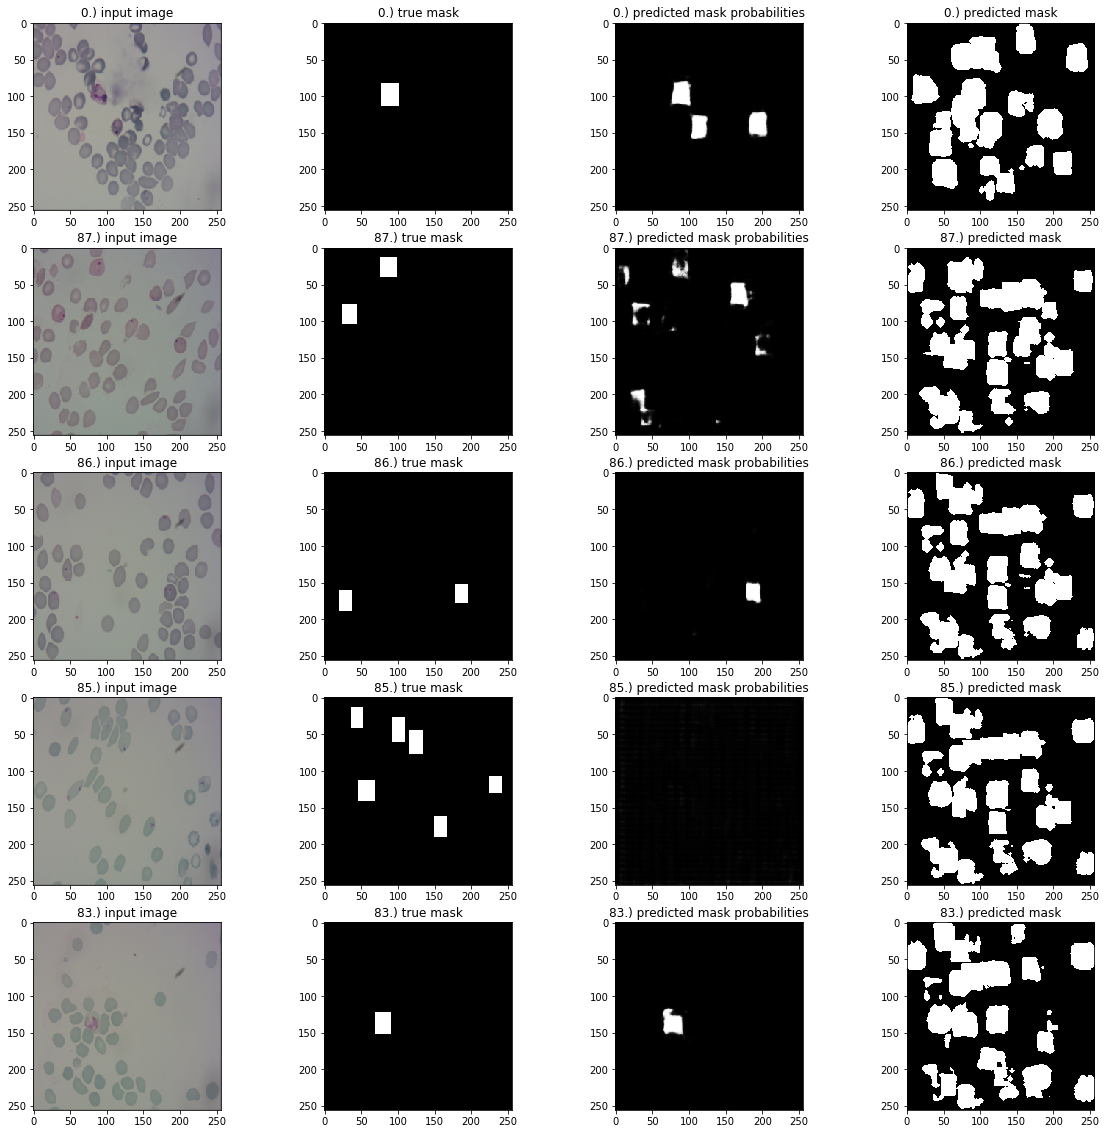

In [83]:
fig, axs = plt.subplots(5,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:5]['index'].values.astype(np.int)

for i,n in enumerate(list_):
    img, img_type = imshow_args(X_test[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(Y_test[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_test_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_test_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

### Plot the best 10 predictions.

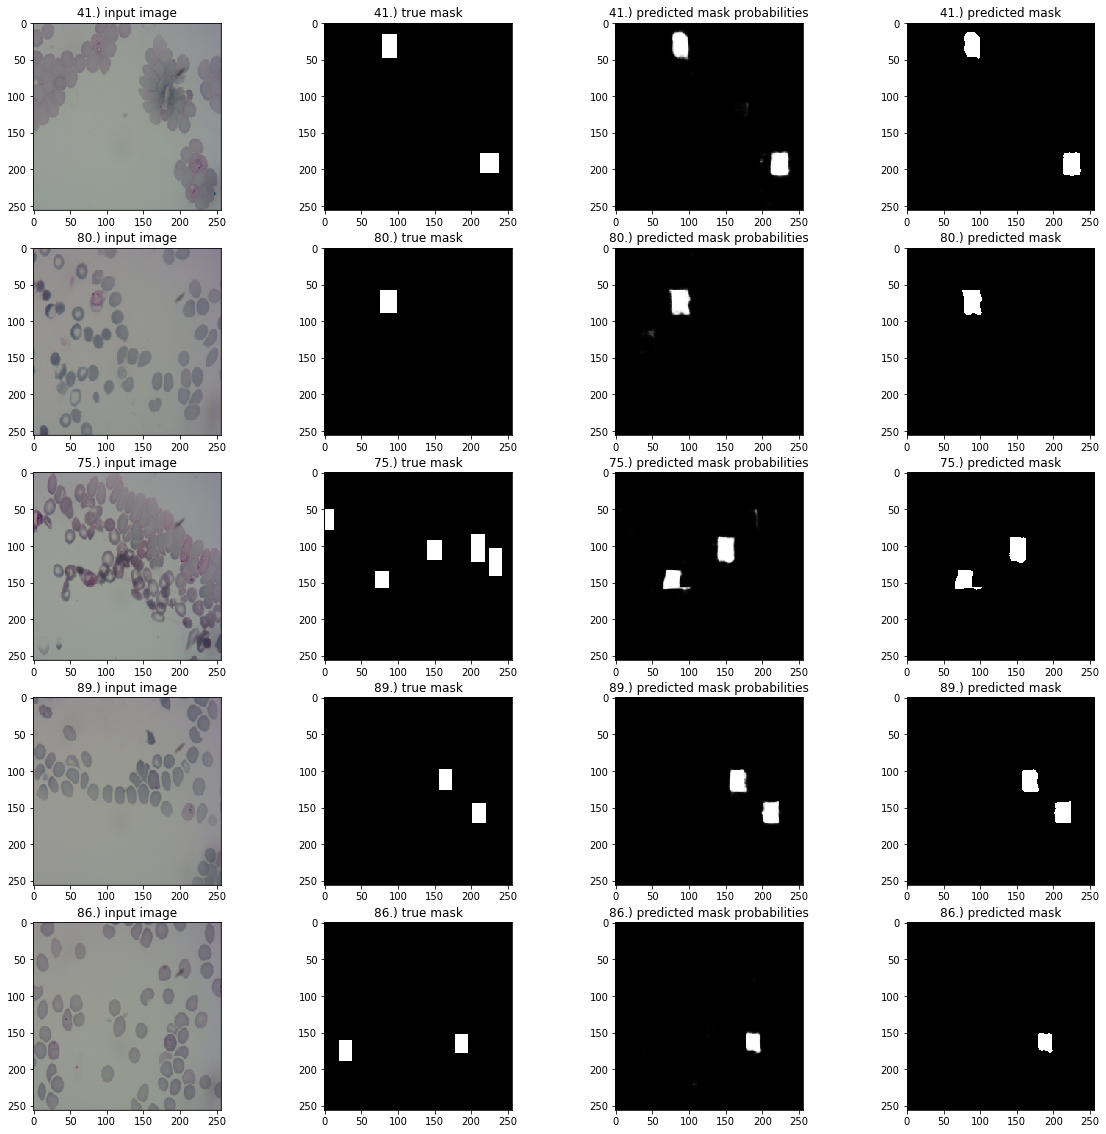

In [122]:
n = 5
fig, axs = plt.subplots(n,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=False)[:n]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(X_test[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(Y_test[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_test_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_test_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

In [123]:
sess.close()

In [ ]:
def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

In [42]:
cutoff=.5
mask = Y_train[0]
mask = mask.reshape(mask.shape[0], mask.shape[1])
lab_mask = skimage.morphology.label(mask > cutoff) 

(mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
print(mask_labels,mask_sizes)


[0 1 2 3] [63551   651   551   783]


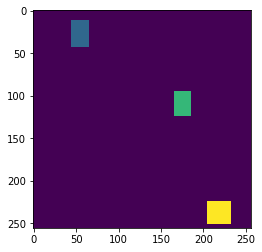

In [43]:
if (mask_sizes < min_object_size).any():
    print(mask_sizes)
    print("A")

plt.imshow(lab_mask)

In [21]:
import pandas as pd

data = pd.read_csv("unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte.log")

In [22]:
data.head()

,epoch,dataset,loss,score,IoU,precision,recall
0,0.01,train,0.9209,0.0000,0.0121,0.0000,0.0000
1,0.01,validation,0.9145,0.0000,0.0125,0.0000,0.0000
2,1.00,train,0.6501,NaN,0.4676,0.0492,0.1539
3,1.00,validation,0.6856,NaN,0.4088,0.0510,0.1317
4,1.99,train,0.4862,0.0934,0.6684,0.0934,0.3743
